# Notebook for the Chemostat Model

In [1]:
import numpy as np
import numpy.ma as ma
import scipy.optimize
import matplotlib.pyplot as plt
import math
import time
import pandas as pd
import seaborn as sns
from matplotlib import ticker, cm
from functools import partial
from scipy.integrate import odeint
from scipy.optimize import fsolve
%matplotlib inline

sns.set()

## Growth functions depending on CTX concentration and parameters

In [2]:
def growth(a, B, T, h, ec50, **kwargs):
    return B + (T-B)/(1 + (a/ec50)**h)

R = Resistant = Triple = TEM-52

S = Susceptible = G238S = TEM-19

In [3]:
p_R = {"Vmax": 3.20e-4, "ka":69, "B": -96.5, "T":0.146, 
       "ec50": 27716, "h": 3.38, "k": 1.8e-4, "yxg": 2e9}
p_S = {"Vmax":6.69e-4, "ka":319, "B": -1.57, "T": 0.183, "ec50": 1.87, 
       "h": 3.42, "k": 1.8e-4, "yxg": 2e9}

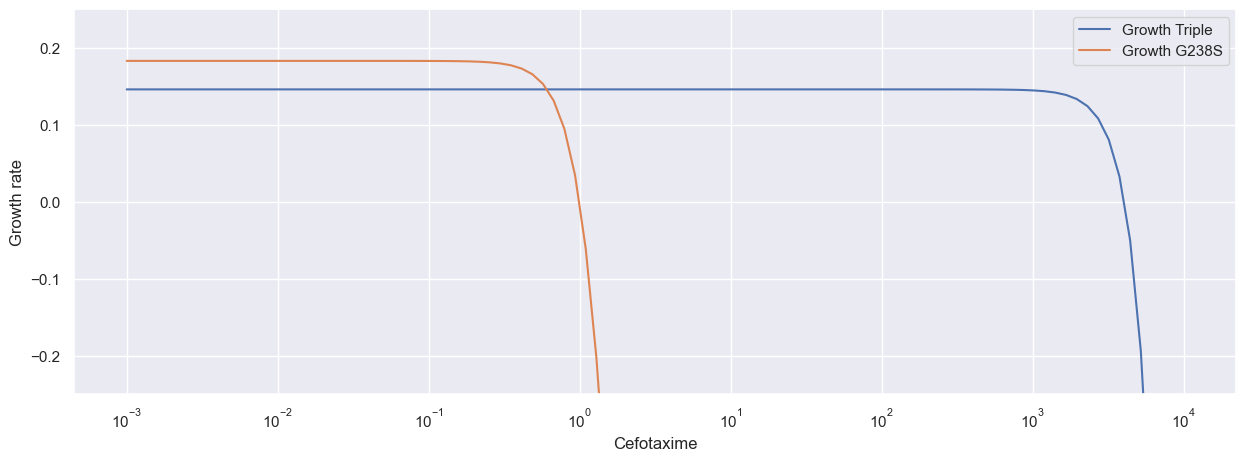

In [4]:
xval = np.logspace(-3, 4, num=100)
yvalx = [growth(a, **p_R) for a in xval]
yvaly = [growth(a, **p_S) for a in xval]
fig, axes = plt.subplots(figsize=(15,5))
axes.plot(xval, yvalx)
axes.plot(xval, yvaly)
axes.set_xlabel('Cefotaxime')
axes.set_ylabel('Growth rate')
axes.set_ylim(-0.25, 0.25)
axes.set_xscale('log')
axes.legend(tuple(['Growth Triple','Growth G238S']))


## Simulation of the chemostat

In [5]:
def chemostat_model(model_state, t, parms):
    g = model_state[0]
    a = model_state[1]
    R = np.array(model_state[2])
    S = np.array(model_state[3])
    if a <= 0:
        a = 1e-9
    yxg = parms[0].get('yxg')
    k = parms[0].get('k')
    ka_R = parms[0].get('ka')
    ka_S = parms[1].get('ka')
    Vmax_R = parms[0].get('Vmax')
    Vmax_S = parms[1].get('Vmax')
    d = parms[2].get('d')
    feed_g = parms[2].get('feed_g')
    feed_a = parms[2].get('feed_a')

    # the growth rates
    mu_R = growth(a, **parms[0])
    mu_S = max(growth(a, **parms[1]), 0)
    d_S = min(0, growth(a, **parms[1]))
    
    # the derivatives
    dgdt = feed_g * d - (1/yxg)*(R*(g/(k+g))*mu_R + S*(g/(k+g))*mu_S) - d*g
    dadt = feed_a * d - Vmax_R*R*(a/(a + ka_R)) - Vmax_S*S*(a/(a + ka_S)) - d*a
    dRdt = R*(g/(k+g))*mu_R - d*R
    dSdt = S*(g/(k+g))*mu_S + S*d_S - d*S

    return np.array([dgdt, dadt, dRdt, dSdt])

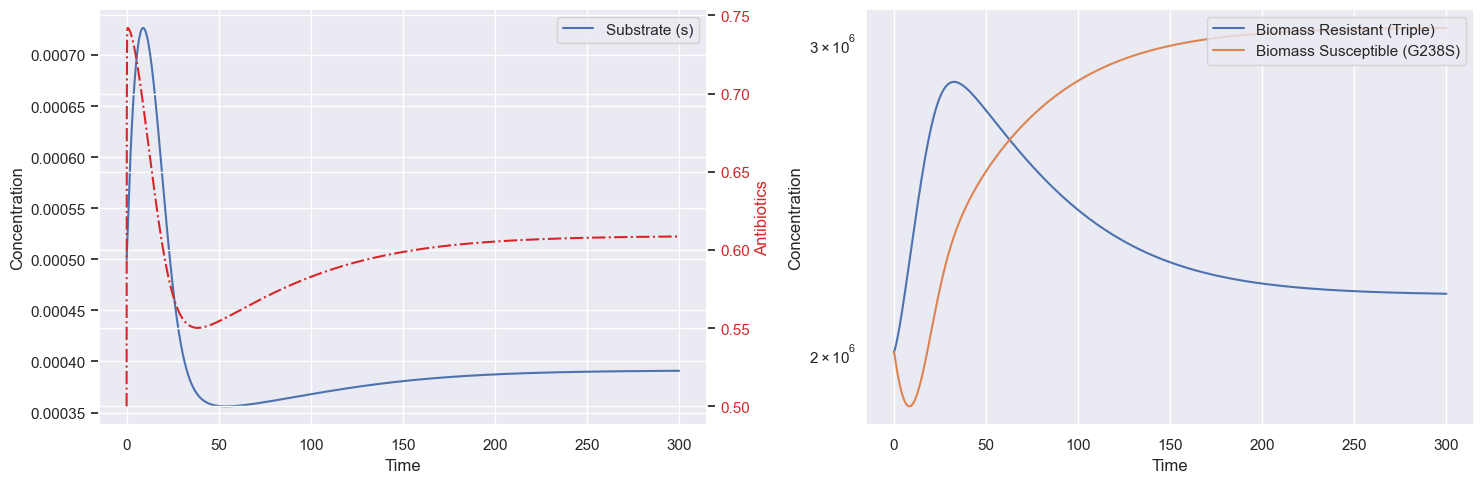

In [6]:
t = np.linspace(0,300,10000)
init = np.array([.0005, .5, 2*10**6, 2*10**6])
p_chemostat = {"d": 0.1, "feed_g": 0.003, "feed_a": 100}

result = odeint(chemostat_model, init, t, args=([p_R, p_S, p_chemostat],))

fig, axes = plt.subplots(1,2, figsize=(15,5))

axes[0].plot(t, result[:,0])
color = 'tab:red'
axes2 = axes[0].twinx()  # instantiate a second axes that shares the same x-axis
axes2.set_ylabel('Antibiotics', color=color)  # we already handled the x-label with ax1
axes2.tick_params(axis='y', labelcolor=color)
axes2.plot(t, result[:,1], '-.', color=color)
    
axes[1].plot(t, result[:,2])
axes[1].plot(t, result[:,3])
    
axes[0].set_xlabel('Time')
axes[1].set_xlabel('Time')
axes[0].set_ylabel('Concentration')
axes[1].set_ylabel('Concentration')
axes[1].set_yscale('log')
#axes[1].set_ylim([1e-3, 1e12])
axes[0].legend(tuple(['Substrate (s)', 'Antibiotics (a)']), loc="upper right")
axes[1].legend(tuple(['Biomass Resistant (Triple)', 'Biomass Susceptible (G238S)']), loc="upper right")
plt.tight_layout()

## Calculations of the coexistence area

First we find the antibiotic concentration for which the maximal growth rate (with respect to substrate) of both strains is equal.

This is the CTX concentrations in the chemostat at a steady state in which both strains are present.

In [7]:
func_equal_growth = lambda a: (growth(a, **p_R) - growth(a, **p_S))**2
sol_a_eq = fsolve(func_equal_growth, 0.6)[0]

In [8]:
mu_coex = growth(sol_a_eq, **p_R)

We find the glycerol concentration under which the strains cannot grow depending on the dilution rate (assuming not antibiotics; so this is based on the growth of the susceptible strain, because that one grows faster without antibiotics).

In [9]:
def g_min(d, mu, k, **kwargs):
    return d*k/(mu-d)

In [10]:
def min_g(d):
    return g_min(d, mu=growth(0, **p_S), **p_S)

We define a function that gives the feed concentration of glycerol depending on the antibiotic feed concentration above which the susceptible is so abundant that it breaks down the antibiotic until under sol_a_eq by itself

In [11]:
def feed_g_R_coex(feed_a, d, a, ka, Vmax, muR, k, yxg, **kwargs):
    return ((1/yxg)*((feed_a - a)*(a + ka)/(a*Vmax))*(muR/(k + d*k/(muR - d)))+1)*(d*k/(muR-d))

We define a function that gives the feed concentration of glycerol depending on the antibiotic feed concentration below which the resistant cannot break down the antibiotic concentration to under sol_a_eq even if the whole population is resistant

In [12]:
def feed_g_coex_S(feed_a, d, a, ka, Vmax, muS, k, yxg, **kwargs):
    return ((1/yxg)*((feed_a - a)*(a + ka)/(a*Vmax))*(muS/(k + d*k/(muS - d)))+1)*(d*k/(muS-d))

Then we calculate the total cell density as a function glucerol feed, assuming that there is coexistence (a = sol_a_eq)

In [13]:
#calculate Ntot in case of coexistence
def N_tot(feed_a, feed_g, d, a, g, ka, Vmax, mu_coex, k, yxg, **kwargs):
    return (k+g)*(feed_g-g)*d*yxg/(g*mu_coex)

Then we calculate the density of the resistant strain as a function glucerol and antibiotics feed, assuming that there is coexistence (a = sol_a_eq)

In [14]:
def N_R_coex(feed_a, d, a, N_tot, parS, parR, **kwargs):
    ka_R = parR.get('ka')
    ka_S = parS.get('ka')
    Vmax_R = parR.get('Vmax')
    Vmax_S = parS.get('Vmax')
    return ((feed_a-a)*d - Vmax_S*N_tot*a/(a+ka_S))/(Vmax_R*a/(a+ka_R) - Vmax_S*a/(a+ka_S))

Calculate the equilibrium ratio and give back:

-1 => no strain can grow \
0 => susceptible only (if a < sol_a_eq or density is high enough for S alone to break down a until under sol_a_eq) \
1 => resistant only (if density is so low that R alone does not break down a until under sol_a_eq) \
number between 0 and 1 => equilibrium ratio of R

In [15]:
def equilibrium_ratio(a, s, d):
    if s < min_g(d):
        return -1
    elif a < sol_a_eq:
        return 0 
    elif s < feed_g_R_coex(a, d, sol_a_eq, muR=growth(sol_a_eq, **p_R), **p_R):
        return 1
    elif s > feed_g_coex_S(a, d, sol_a_eq, muS=growth(sol_a_eq, **p_S), **p_S):
        return 0
    else:
        N_tot_temp = N_tot(a, s, d, sol_a_eq, g_min(d, growth(sol_a_eq, **p_R), **p_R), mu_coex = growth(sol_a_eq, **p_R), **p_R)
        return N_R_coex(a, d, sol_a_eq, N_tot_temp, p_S, p_R)/N_tot_temp

Calculate the total population size

This does not take into account that when there is S only there might be antibiotics decreasing the growth rate.

In [16]:
def population_size(a, s, d):
    if s <= min_g(d):
        return 0
    elif a < sol_a_eq:
        return N_tot(a, s, d, 0, g_min(d, growth(0, **p_S), **p_S), mu_coex = growth(0, **p_S), **p_S)
    elif s < feed_g_R_coex(a, d, sol_a_eq, muR=growth(sol_a_eq, **p_R), **p_R):
        return N_tot(a, s, d, sol_a_eq, g_min(d, growth(sol_a_eq, **p_R), **p_R), mu_coex = growth(sol_a_eq, **p_R), **p_R)
    elif s > feed_g_coex_S(a, d, sol_a_eq, muS=growth(sol_a_eq, **p_S), **p_S):
        return N_tot(a, s, d, 0, g_min(d, growth(0, **p_S), **p_S), mu_coex = growth(0, **p_S), **p_S)
    else:
        return N_tot(a, s, d, sol_a_eq, g_min(d, growth(sol_a_eq, **p_R), **p_R), mu_coex = growth(sol_a_eq, **p_R), **p_R)

### Printing some of the results and checks for some of the values

In [17]:
print('minimum g to survive for susceptible strain at d=0.1', min_g(0.1))
print('minimum g to survive for resistant strain at d=0.1', g_min(0.1, mu=growth(0, **p_R), **p_R))
print('a equal growth', sol_a_eq, 'mu_coex', mu_coex, 'check', growth(sol_a_eq, **p_R), growth(sol_a_eq, **p_S))
print('this should be 74.7735:', feed_g_R_coex(400, 0.08, 0.57,67, 0.0002384*1.8, 0.146, 1, 1.2e5))
N_tot_temp = N_tot(30,.001, 0.1, sol_a_eq, g_min(0.1, mu_coex, **p_R), mu_coex=growth(0, **p_R),**p_R)
print('N_tot', N_tot_temp)
N_R_temp = N_R_coex(30,0.1, sol_a_eq, N_tot_temp, p_S, p_R)
print('N_R', N_R_temp)
print('ratio', N_R_temp/N_tot_temp)

minimum g to survive for susceptible strain at d=0.1 0.00021686746987951795
minimum g to survive for resistant strain at d=0.1 0.00039130434782608025
a equal growth 0.6089965534101354 mu_coex 0.14599999999997237 check 0.14599999999997237 0.14599999999997393
this should be 74.7735: 74.77347756877222
N_tot 1217391.3043471186
N_R 909737.5376397033
ratio 0.747284405918762


### Plotting a contourplot with the equilibrium ratio

We make a version of the function that can be used to calculate a mesh grid

In [18]:
equilibrium_ratio_d01 = partial(equilibrium_ratio, d=0.1)
equilibrium_ratio_array = np.frompyfunc(equilibrium_ratio_d01, 2, 1)

We define the ranges for the feed concentrations of a (CTX, ug/ml) and s (glycerol, %)

In [19]:
a_list = np.geomspace(.1,1000,400)
s_list = np.geomspace(0.0001,0.04,400)

A, S = np.meshgrid(a_list, s_list)
EQ = equilibrium_ratio_array(A,S)
EQ_ma = ma.masked_values(EQ, -1)

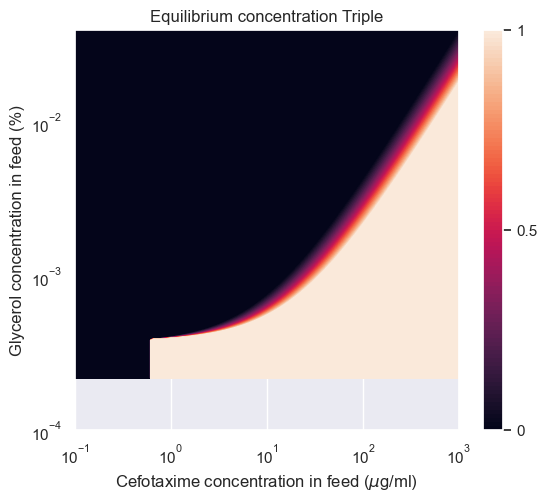

In [20]:
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

levels = np.linspace(0,1,101, endpoint=True)
cp = plt.contourf(A, S, EQ_ma, levels)
cbar = plt.colorbar(cp)
cbar.set_ticks([0,.5,1])
cbar.set_ticklabels([0,.5,1])

ax.set_title('Equilibrium concentration Triple')
ax.set_xlabel(r'Cefotaxime concentration in feed ($\mu$g/ml)')
ax.set_ylabel('Glycerol concentration in feed (%)')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(.1, 1000)
ax.set_ylim(0.0001, 0.04)
plt.show()

## Regular addition of antibiotics

Function to repeatedly simulate a chemostat with 100 timesteps per hour

In [21]:
def serial_chemostat(model, init, iterations, interval, amount, parms):
    timeadd = 0
    sol = []
    t = np.linspace(0,interval,int(np.round(interval*100)))
    for i in range(0, iterations):
        #set up model
        sol = odeint(chemostat_model, init, t, args=parms)
        #adjust the time
        if i==0:
            totalsol = sol
        else:
            totalsol = np.concatenate((totalsol,sol))
        #reset
        init = sol[-1]+np.array([0,amount,0,0])
        sol = []
    return totalsol

Example simulation of a chemostat with regular addition of antibiotics

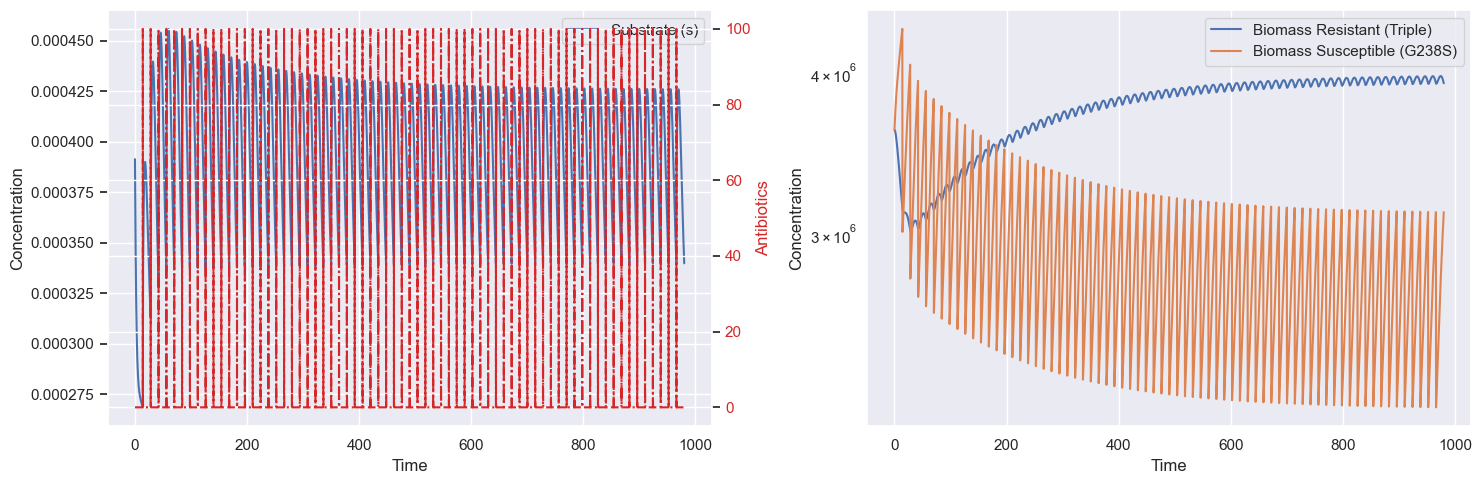

In [22]:
iterations = 70
interval = 14
amount = 100
g_feed_test = 0.004
a_feed_test = 0
d_graph = 0.1

approx_ss_popsize = N_tot(a_feed_test, g_feed_test, d_graph, sol_a_eq, g_min(d_graph, growth(sol_a_eq, **p_R), **p_R), mu_coex = growth(sol_a_eq, **p_R), **p_R)
approx_gly = g_min(d_graph, growth(0, **p_R), **p_R)

t = np.linspace(0,interval*iterations,100*iterations*interval)
init = np.array([approx_gly, 0, 0.5*approx_ss_popsize, 0.5*approx_ss_popsize])
p_chemostat_intermittend = {"d": 0.1, "feed_g": g_feed_test, "feed_a": 0}

result = serial_chemostat(chemostat_model, init, iterations, interval, amount, parms=([p_R, p_S, p_chemostat_intermittend],))

fig, axes = plt.subplots(1,2, figsize=(15,5))

axes[0].plot(t, result[:,0])
color = 'tab:red'
axes2 = axes[0].twinx()  # instantiate a second axes that shares the same x-axis
axes2.set_ylabel('Antibiotics', color=color)  # we already handled the x-label with ax1
axes2.tick_params(axis='y', labelcolor=color)
axes2.plot(t, result[:,1], '-.', color=color)
    
axes[1].plot(t, result[:,2])
axes[1].plot(t, result[:,3])
    
axes[0].set_xlabel('Time')
axes[1].set_xlabel('Time')
axes[0].set_ylabel('Concentration')
axes[1].set_ylabel('Concentration')
axes[1].set_yscale('log')
#axes[1].set_ylim([1e-3, 1e12])
axes[0].legend(tuple(['Substrate (s)', 'Antibiotics (a)']), loc="upper right")
axes[1].legend(tuple(['Biomass Resistant (Triple)', 'Biomass Susceptible (G238S)']), loc="upper right")
plt.tight_layout()

These functions calculate the equilibrium ratio of the Triple in the chemostat by first checking high and low ratios, doing 3 iterations and checking if the ratio decreases between the second and third iteration (because the chemostat will not be steady state and in the beginning there are no antibiotics, we take the second and third iteration).

In [23]:
#This functions gives the ratio of the triple at a certain model state
def calc_ratio(model_state):
    return model_state[2]/(model_state[2]+model_state[3])

In [24]:
def equilibrium_ratio_serial(feed_g, interval, amount, d, p_R, p_S, sensitivity=0.001, max_iterations=50):
    approx_ss_popsize = N_tot(a_feed_test, g_feed_test, d_graph, sol_a_eq, g_min(d_graph, growth(sol_a_eq, **p_R), **p_R), mu_coex = growth(sol_a_eq, **p_R), **p_R)
    approx_gly = g_min(d_graph, growth(0, **p_R), **p_R)
    ratio_low = 0 + sensitivity
    ratio_high = 1 - sensitivity
    iterations = 0
    p_chemostat = {"d": d, "feed_g": feed_g, "feed_a": 0}
    init_low = np.array([approx_gly, 0, (1-ratio_high)*approx_ss_popsize, ratio_high*approx_ss_popsize])
    sim_low = serial_chemostat(chemostat_model, init_low, 3, interval, amount, parms=([p_R, p_S, p_chemostat],))
    sim_low_start = sim_low[sim_low[:,1]>(amount-0.0001)]
    if calc_ratio(sim_low_start[-1]) < calc_ratio(sim_low_start[0]):
        return 0
    init_high = np.array([approx_gly, 0, (1-ratio_low)*approx_ss_popsize, ratio_low*approx_ss_popsize])
    sim_high = serial_chemostat(chemostat_model, init_high, 3, interval, amount, parms=([p_R, p_S, p_chemostat],))
    sim_high_start = sim_high[sim_high[:,1]>(amount-0.0001)]    
    if calc_ratio(sim_high_start[-1]) > calc_ratio(sim_high_start[0]):
        return 1
    while abs(ratio_high - ratio_low) > sensitivity:
#        print('iteration', iterations)
        if iterations == max_iterations:
            print("Precision not reached: Difference is", abs(ratio_high - ratio_low))
            break
        ratio_check = ratio_low + 0.5*(ratio_high - ratio_low)
        init_check = np.array([approx_gly, 0, (ratio_check)*approx_ss_popsize, (1-ratio_check)*approx_ss_popsize])
        sim = serial_chemostat(chemostat_model, init_check, 3, interval, amount, parms=([p_R, p_S, p_chemostat],))
        sim_start = sim[sim[:,1]>(amount-0.0001)]
#        print('ratio', ratio_check, 'sim_start', sim_start)
        if calc_ratio(sim_start[-1]) > calc_ratio(sim_start[0]):
            ratio_low = ratio_check
        elif calc_ratio(sim_start[-1]) < calc_ratio(sim_start[0]):
            ratio_high = ratio_check
        iterations += 1
    return ratio_low + (ratio_high-ratio_low)/2

We create a partial function with 100 ug/ml CTX added at the interval and for a dilution rate of 0.1/h.

In [25]:
eq_ratio_partial = partial(equilibrium_ratio_serial, amount=100, d=0.1, p_R=p_R, p_S=p_S, sensitivity=0.001, max_iterations=50)
equilibrium_ratio_array_intermittend = np.frompyfunc(eq_ratio_partial, 2, 1)

If saved data is used the line between 'tic' and 'toc' should be commented as wel as the export line.
Otherwise the load data should be commented

In [70]:
interval_array = np.linspace(5,50,100, endpoint=True)
glycerol_array = np.geomspace(0.0004,0.04,100)

I, G = np.meshgrid(interval_array, glycerol_array)
tic = time.perf_counter()
EQ_intermittend = equilibrium_ratio_array_intermittend(G, I)
toc = time.perf_counter()
print(f"The simulations take {toc - tic:0.4f} seconds")

The simulations take 957.6503 seconds


In [71]:
#export data
#np.save('data/eqratios_intermittend2.npy', EQ_intermittend, allow_pickle=True)

In [78]:
#load data
EQ_intermittend = np.load('data/eqratios_intermittend.npy', allow_pickle=True)

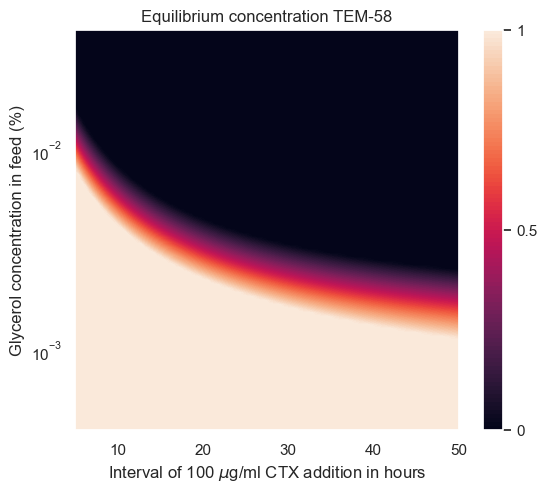

In [79]:
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

levels = np.linspace(0,1,101, endpoint=True)
cp = plt.contourf(I, G, EQ_intermittend, levels)
cbar = plt.colorbar(cp)
cbar.set_ticks([0,.5,1])
cbar.set_ticklabels([0,.5,1])

ax.set_title('Equilibrium concentration TEM-58')
ax.set_xlabel(r'Interval of 100 $\mu$g/ml CTX addition in hours')
ax.set_ylabel('Glycerol concentration in feed (%)')
ax.set_yscale('log')
ax.set_xlim(5, 50)
ax.set_ylim(0.0004, 0.04)
plt.show()

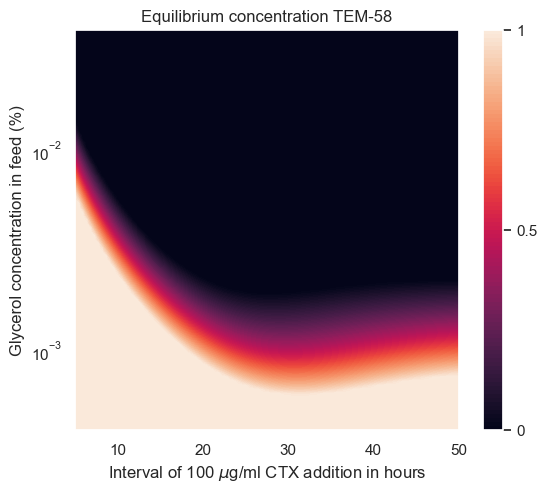

In [90]:
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

levels = np.linspace(0,1,101, endpoint=True)
cp = plt.contourf(I, G, EQ_intermittend_test, levels)
cbar = plt.colorbar(cp)
cbar.set_ticks([0,.5,1])
cbar.set_ticklabels([0,.5,1])

ax.set_title('Equilibrium concentration TEM-58')
ax.set_xlabel(r'Interval of 100 $\mu$g/ml CTX addition in hours')
ax.set_ylabel('Glycerol concentration in feed (%)')
ax.set_yscale('log')
ax.set_xlim(5, 50)
ax.set_ylim(0.0004, 0.04)
plt.show()

Test voor interval=30 en Gly=0.001 (oud=resistant wins; new=coex)

Equilibrium ratio TEM-58 according to algorithm: 1


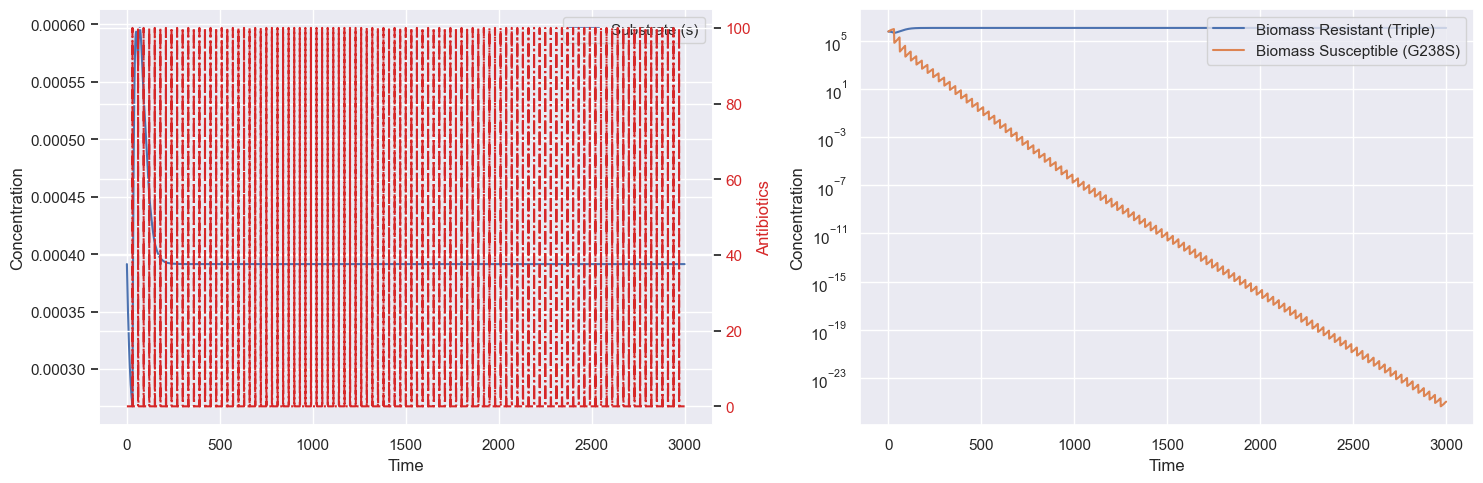

In [93]:
iterations = 100
interval = 30
amount = 100
g_feed_test = 0.001
a_feed_test = 0
d_graph = 0.1

print('Equilibrium ratio TEM-58 according to algorithm:', equilibrium_ratio_serial(g_feed_test, interval, amount, d_graph, p_R, p_S))

approx_ss_popsize = N_tot(a_feed_test, g_feed_test, d_graph, sol_a_eq, g_min(d_graph, growth(sol_a_eq, **p_R), **p_R), mu_coex = growth(sol_a_eq, **p_R), **p_R)
approx_gly = g_min(d_graph, growth(0, **p_R), **p_R)

t = np.linspace(0,interval*iterations,100*iterations*interval)
init = np.array([approx_gly, 0, 0.5*approx_ss_popsize, 0.5*approx_ss_popsize])
p_chemostat_intermittend = {"d": 0.1, "feed_g": g_feed_test, "feed_a": 0}

result = serial_chemostat(chemostat_model, init, iterations, interval, amount, parms=([p_R, p_S, p_chemostat_intermittend],))

fig, axes = plt.subplots(1,2, figsize=(15,5))

axes[0].plot(t, result[:,0])
color = 'tab:red'
axes2 = axes[0].twinx()  # instantiate a second axes that shares the same x-axis
axes2.set_ylabel('Antibiotics', color=color)  # we already handled the x-label with ax1
axes2.tick_params(axis='y', labelcolor=color)
axes2.plot(t, result[:,1], '-.', color=color)
    
axes[1].plot(t, result[:,2])
axes[1].plot(t, result[:,3])
    
axes[0].set_xlabel('Time')
axes[1].set_xlabel('Time')
axes[0].set_ylabel('Concentration')
axes[1].set_ylabel('Concentration')
axes[1].set_yscale('log')
#axes[1].set_ylim([1e-3, 1e12])
axes[0].legend(tuple(['Substrate (s)', 'Antibiotics (a)']), loc="upper right")
axes[1].legend(tuple(['Biomass Resistant (Triple)', 'Biomass Susceptible (G238S)']), loc="upper right")
plt.tight_layout()

Check for short intervals and high population size

Equilibrium ratio TEM-58 according to algorithm: 0


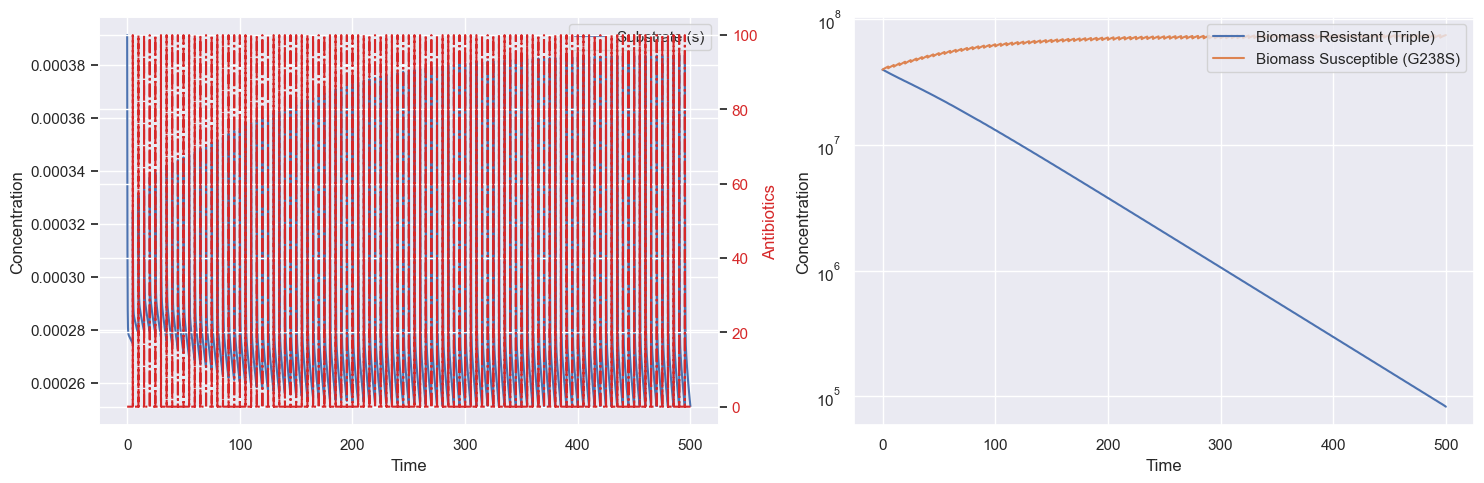

In [80]:
iterations = 100
interval = 5
amount = 100
g_feed_test = 0.04
a_feed_test = 0
d_graph = 0.1

print('Equilibrium ratio TEM-58 according to algorithm:', equilibrium_ratio_serial(g_feed_test, interval, amount, d_graph, p_R, p_S))

approx_ss_popsize = N_tot(a_feed_test, g_feed_test, d_graph, sol_a_eq, g_min(d_graph, growth(sol_a_eq, **p_R), **p_R), mu_coex = growth(sol_a_eq, **p_R), **p_R)
approx_gly = g_min(d_graph, growth(0, **p_R), **p_R)

t = np.linspace(0,interval*iterations,100*iterations*interval)
init = np.array([approx_gly, 0, 0.5*approx_ss_popsize, 0.5*approx_ss_popsize])
p_chemostat_intermittend = {"d": 0.1, "feed_g": g_feed_test, "feed_a": 0}

result = serial_chemostat(chemostat_model, init, iterations, interval, amount, parms=([p_R, p_S, p_chemostat_intermittend],))

fig, axes = plt.subplots(1,2, figsize=(15,5))

axes[0].plot(t, result[:,0])
color = 'tab:red'
axes2 = axes[0].twinx()  # instantiate a second axes that shares the same x-axis
axes2.set_ylabel('Antibiotics', color=color)  # we already handled the x-label with ax1
axes2.tick_params(axis='y', labelcolor=color)
axes2.plot(t, result[:,1], '-.', color=color)
    
axes[1].plot(t, result[:,2])
axes[1].plot(t, result[:,3])
    
axes[0].set_xlabel('Time')
axes[1].set_xlabel('Time')
axes[0].set_ylabel('Concentration')
axes[1].set_ylabel('Concentration')
axes[1].set_yscale('log')
#axes[1].set_ylim([1e-3, 1e12])
axes[0].legend(tuple(['Substrate (s)', 'Antibiotics (a)']), loc="upper right")
axes[1].legend(tuple(['Biomass Resistant (Triple)', 'Biomass Susceptible (G238S)']), loc="upper right")
plt.tight_layout()

In [81]:
#convert interval to doses per day (24/interval)
I_new = 24/I

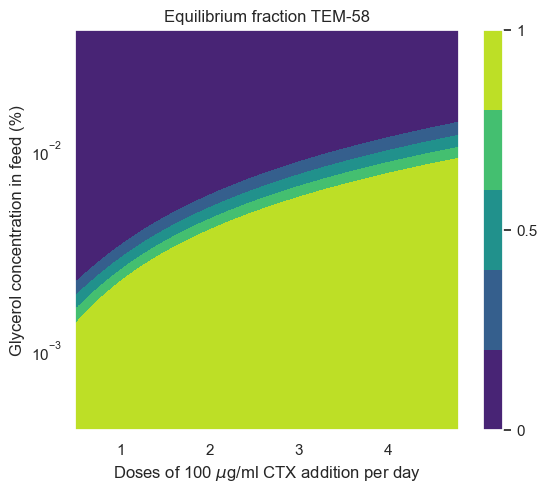

In [82]:
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

levels = np.linspace(0,1,101, endpoint=True)
cp = plt.contourf(I_new, G, EQ_intermittend, levels=4,cmap=cm.viridis)
cbar = plt.colorbar(cp)
cbar.set_ticks([0,.5,1])
cbar.set_ticklabels([0,.5,1])

ax.set_title('Equilibrium fraction TEM-58')
ax.set_xlabel(r'Doses of 100 $\mu$g/ml CTX addition per day')
ax.set_ylabel('Glycerol concentration in feed (%)')
ax.set_yscale('log')
ax.set_xlim(24/50, 24/5)
ax.set_ylim(0.0004, 0.04)

#plt.savefig("chemostat_figure_doses.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Go from glycerol concentration to approximate density

We calculate the density a strain or combination of strains would reach as function of the glycerol concentrations in the feed, when no antibiotics would be added (but a strain or coexistence would be imposed -> in the case of coexistence this is of course an approximation because there would be no coexistence without antibiotics addition). 

This differs for resident strains, so we calculate it for three cases:
1. susceptible resident
2. resistent resident
3. coexistence

In [83]:
d_graph = 0.1
a_feed_test = 0 # should nog have any influence

In [84]:
#in case of susceptible resident
popsize_S = [N_tot(a_feed_test, g_feed, d_graph, 0, g_min(d_graph, growth(0, **p_S), **p_S), mu_coex = growth(0, **p_S), **p_S) for g_feed in glycerol_array]
#in case of resistent resident
popsize_R = [N_tot(a_feed_test, g_feed, d_graph, 0, g_min(d_graph, growth(0, **p_R), **p_R), mu_coex = growth(0, **p_R), **p_R) for g_feed in glycerol_array]
#in case of equilibrium
popsize_coex = [N_tot(a_feed_test, g_feed, d_graph, sol_a_eq, g_min(d_graph, growth(sol_a_eq, **p_R), **p_R), mu_coex = growth(sol_a_eq, **p_R), **p_R) for g_feed in glycerol_array]

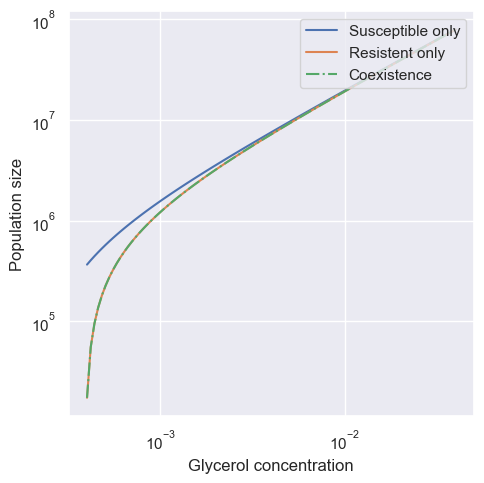

In [85]:
fig, axes = plt.subplots(1,1, figsize=(5,5))

axes.plot(glycerol_array, popsize_S)
axes.plot(glycerol_array, popsize_R)
axes.plot(glycerol_array, popsize_coex, '-.')

axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel('Glycerol concentration')
axes.set_ylabel('Population size')
axes.legend(tuple(['Susceptible only', 'Resistent only', 'Coexistence']), loc="upper right")
plt.tight_layout()

Resistent and coex population size are approximately the same. The susceptible population size mostly differs at low glycerol concentrations, and that is when we most find the resistant strain, so we decided to use the coexistence population size to calculate the approximate steady state population size.

In [86]:
I_P, P = np.meshgrid(interval_array, popsize_coex)

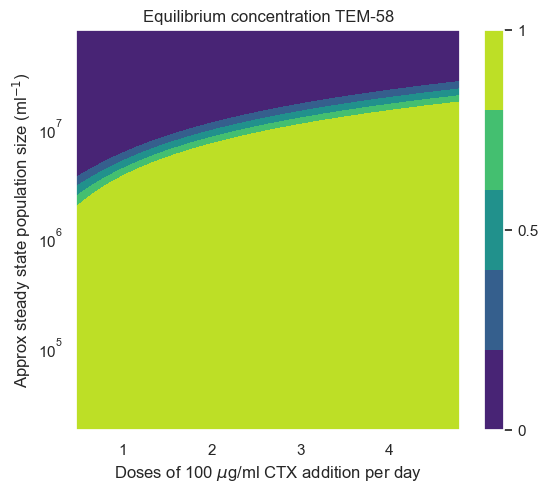

In [89]:
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

levels = np.linspace(0,1,101, endpoint=True)
cp = plt.contourf(I_new, P, EQ_intermittend, levels=4,cmap=cm.viridis)
cbar = plt.colorbar(cp)
cbar.set_ticks([0,.5,1])
cbar.set_ticklabels([0,.5,1])

ax.set_title('Equilibrium concentration TEM-58')
ax.set_xlabel(r'Doses of 100 $\mu$g/ml CTX addition per day')
ax.set_ylabel('Approx steady state population size (ml$^{-1}$)')
ax.set_yscale('log')
ax.set_xlim(24/50, 24/5)

#plt.savefig("chemostat_figure_doses.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Checks of the population size and equilibrium ratio

Check with the resistant only

Reaches the calculated population size

In [38]:
iterations = 70
interval = 10
amount = 100
g_feed_test = 0.004

approx_ss_popsize = N_tot(a_feed_test, g_feed_test, d_graph, sol_a_eq, g_min(d_graph, growth(sol_a_eq, **p_R), **p_R), mu_coex = growth(sol_a_eq, **p_R), **p_R)

t = np.linspace(0,interval*iterations,100*iterations*interval)
init = np.array([g_min(d_graph, growth(0, **p_R), **p_R)*0.99, 0, 1*approx_ss_popsize, 0*approx_ss_popsize])
p_chemostat_intermittend = {"d": 0.1, "feed_g": g_feed_test, "feed_a": 0}

result = serial_chemostat(chemostat_model, init, iterations, interval, amount, parms=([p_R, p_S, p_chemostat_intermittend],))

In [39]:
eq_serial_plot = equilibrium_ratio_serial(g_feed_test, interval, amount, d_graph, p_R, p_S, sensitivity=0.001, max_iterations=50)
print(eq_serial_plot)

1


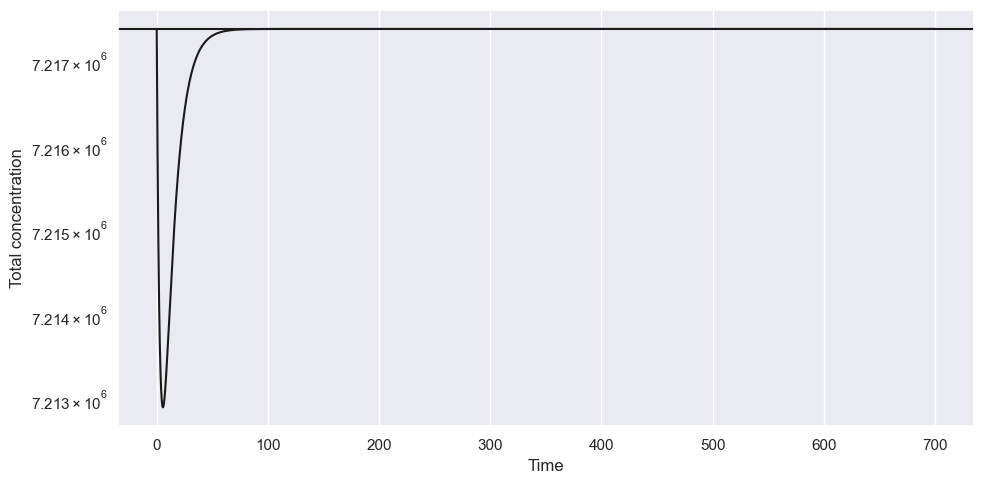

In [40]:
fig, axes = plt.subplots(1,1, figsize=(10,5))

axes.plot(t, result[:,2]+result[:,3], 'k')
    
axes.set_xlabel('Time')
axes.set_ylabel('Total concentration')
axes.set_yscale('log')
axes.axhline(y = approx_ss_popsize, color = 'k', linestyle = '-')
plt.tight_layout()

Check with the susceptible only

Reaches the predicted population size but fluctuations remain because of the effect of the antibiotics

In [41]:
iterations = 70
interval = 24
amount = 100
g_feed_test = 0.004

approx_ss_popsize = N_tot(a_feed_test, g_feed_test, d_graph, sol_a_eq, g_min(d_graph, growth(sol_a_eq, **p_R), **p_R), mu_coex = growth(sol_a_eq, **p_R), **p_R)

t = np.linspace(0,interval*iterations,100*iterations*interval)
init = np.array([g_min(d_graph, growth(0, **p_R), **p_R)*0.99, 0, 0*approx_ss_popsize, 1*approx_ss_popsize])
p_chemostat_intermittend = {"d": 0.1, "feed_g": g_feed_test, "feed_a": 0}

result = serial_chemostat(chemostat_model, init, iterations, interval, amount, parms=([p_R, p_S, p_chemostat_intermittend],))

In [42]:
eq_serial_plot = equilibrium_ratio_serial(g_feed_test, interval, amount, d_graph, p_R, p_S, sensitivity=0.001, max_iterations=50)
print(eq_serial_plot)

0


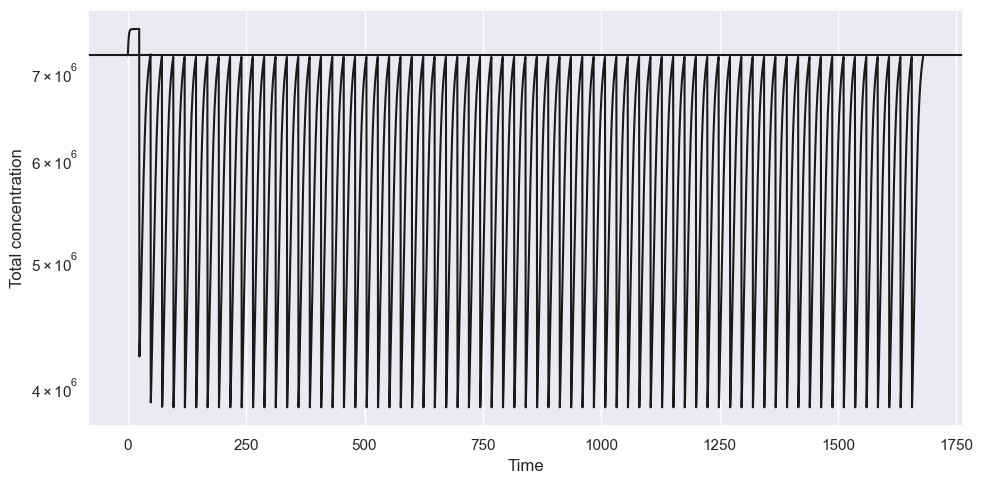

In [43]:
fig, axes = plt.subplots(1,1, figsize=(10,5))

axes.plot(t, result[:,2]+result[:,3], 'k')
    
axes.set_xlabel('Time')
axes.set_ylabel('Total concentration')
axes.set_yscale('log')
axes.axhline(y = approx_ss_popsize, color = 'k', linestyle = '-')
plt.tight_layout()

Check with coexistence

Stays slightly below the predicted population size because never fully recovers from the effect of the antibiotics.

In [44]:
iterations = 70
interval = 14
amount = 100
g_feed_test = 0.004

approx_ss_popsize = N_tot(a_feed_test, g_feed_test, d_graph, sol_a_eq, g_min(d_graph, growth(sol_a_eq, **p_R), **p_R), mu_coex = growth(sol_a_eq, **p_R), **p_R)

t = np.linspace(0,interval*iterations,100*iterations*interval)
init = np.array([g_min(d_graph, growth(0, **p_R), **p_R)*0.99, 0, 0.5*approx_ss_popsize, 0.5*approx_ss_popsize])
p_chemostat_intermittend = {"d": 0.1, "feed_g": g_feed_test, "feed_a": 0}

result = serial_chemostat(chemostat_model, init, iterations, interval, amount, parms=([p_R, p_S, p_chemostat_intermittend],))

In [45]:
eq_serial_plot = equilibrium_ratio_serial(g_feed_test, interval, amount, d_graph, p_R, p_S, sensitivity=0.001, max_iterations=50)
print(eq_serial_plot)

0.5959990234374999


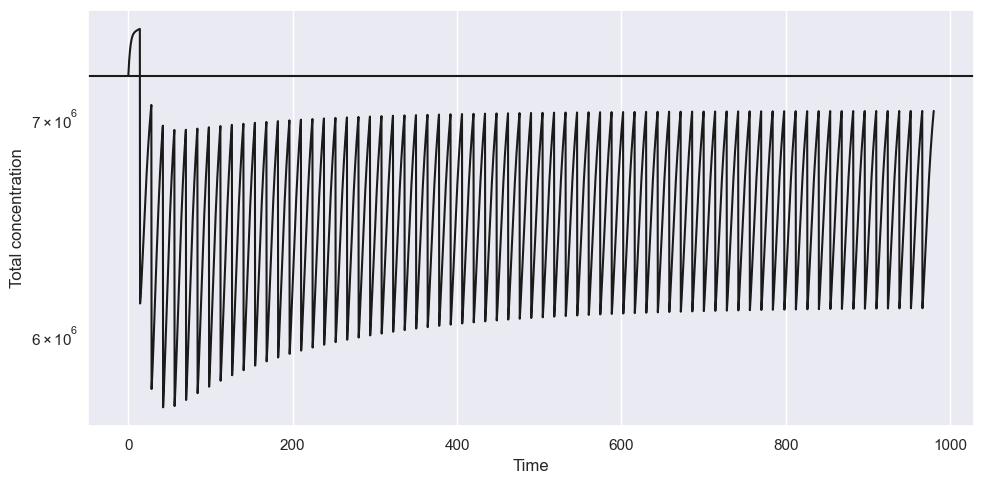

In [46]:
fig, axes = plt.subplots(1,1, figsize=(10,5))

axes.plot(t, result[:,2]+result[:,3], 'k')
    
axes.set_xlabel('Time')
axes.set_ylabel('Total concentration')
axes.set_yscale('log')
axes.axhline(y = approx_ss_popsize, color = 'k', linestyle = '-')
plt.tight_layout()

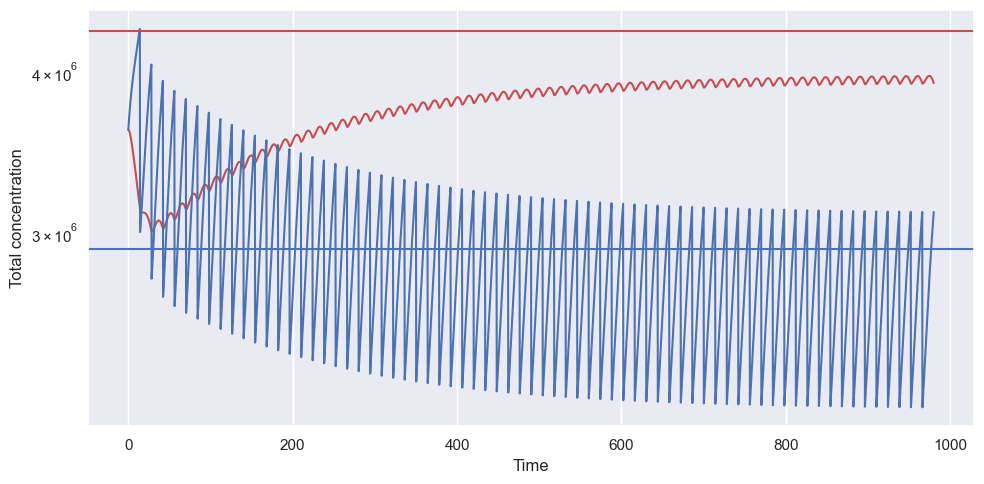

In [47]:
fig, axes = plt.subplots(1,1, figsize=(10,5))

axes.plot(t, result[:,2], 'r')
axes.plot(t, result[:,3], 'b')
    
axes.set_xlabel('Time')
axes.set_ylabel('Total concentration')
axes.set_yscale('log')
axes.axhline(y = eq_serial_plot*approx_ss_popsize, color = 'r', linestyle = '-')
axes.axhline(y = (1-eq_serial_plot)*approx_ss_popsize, color = 'b', linestyle = '-')
plt.tight_layout()

### Figure at different dilution rates (supplementary figures)

In [48]:
equilibrium_ratio_d008 = partial(equilibrium_ratio, d=0.08)
equilibrium_ratio_array_d008 = np.frompyfunc(equilibrium_ratio_d008, 2, 1)

a_list_d008 = np.geomspace(.1,1000,400)
s_list_d008 = np.geomspace(0.0001,0.04,400)

A_d008, S_d008 = np.meshgrid(a_list_d008, s_list_d008)
EQ_d008 = equilibrium_ratio_array_d008(A_d008,S_d008)
EQ_d008_ma = ma.masked_values(EQ_d008, -1)

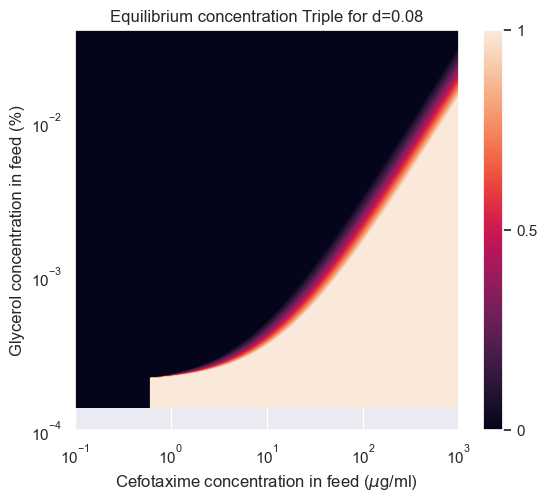

In [49]:
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

levels = np.linspace(0,1,101, endpoint=True)
cp = plt.contourf(A_d008, S_d008, EQ_d008_ma, levels)
cbar = plt.colorbar(cp)
cbar.set_ticks([0,.5,1])
cbar.set_ticklabels([0,.5,1])

ax.set_title('Equilibrium concentration Triple for d=0.08')
ax.set_xlabel(r'Cefotaxime concentration in feed ($\mu$g/ml)')
ax.set_ylabel('Glycerol concentration in feed (%)')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(.1, 1000)
ax.set_ylim(0.0001, 0.04)
plt.show()

In [50]:
equilibrium_ratio_d012 = partial(equilibrium_ratio, d=0.12)
equilibrium_ratio_array_d012 = np.frompyfunc(equilibrium_ratio_d012, 2, 1)

a_list_d012 = np.geomspace(.1,1000,400)
s_list_d012 = np.geomspace(0.0001,0.04,400)

A_d012, S_d012 = np.meshgrid(a_list_d012, s_list_d012)
EQ_d012 = equilibrium_ratio_array_d012(A_d012,S_d012)
EQ_d012_ma = ma.masked_values(EQ_d012, -1)

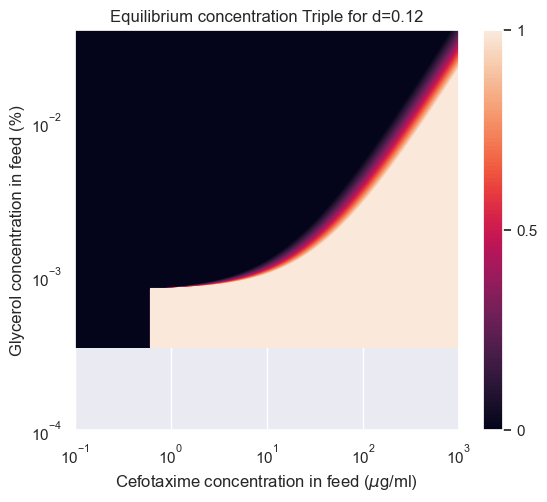

In [51]:
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

levels = np.linspace(0,1,101, endpoint=True)
cp = plt.contourf(A_d012, S_d012, EQ_d012_ma, levels)
cbar = plt.colorbar(cp)
cbar.set_ticks([0,.5,1])
cbar.set_ticklabels([0,.5,1])

ax.set_title('Equilibrium concentration Triple for d=0.12')
ax.set_xlabel(r'Cefotaxime concentration in feed ($\mu$g/ml)')
ax.set_ylabel('Glycerol concentration in feed (%)')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(.1, 1000)
ax.set_ylim(0.0001, 0.04)
plt.show()

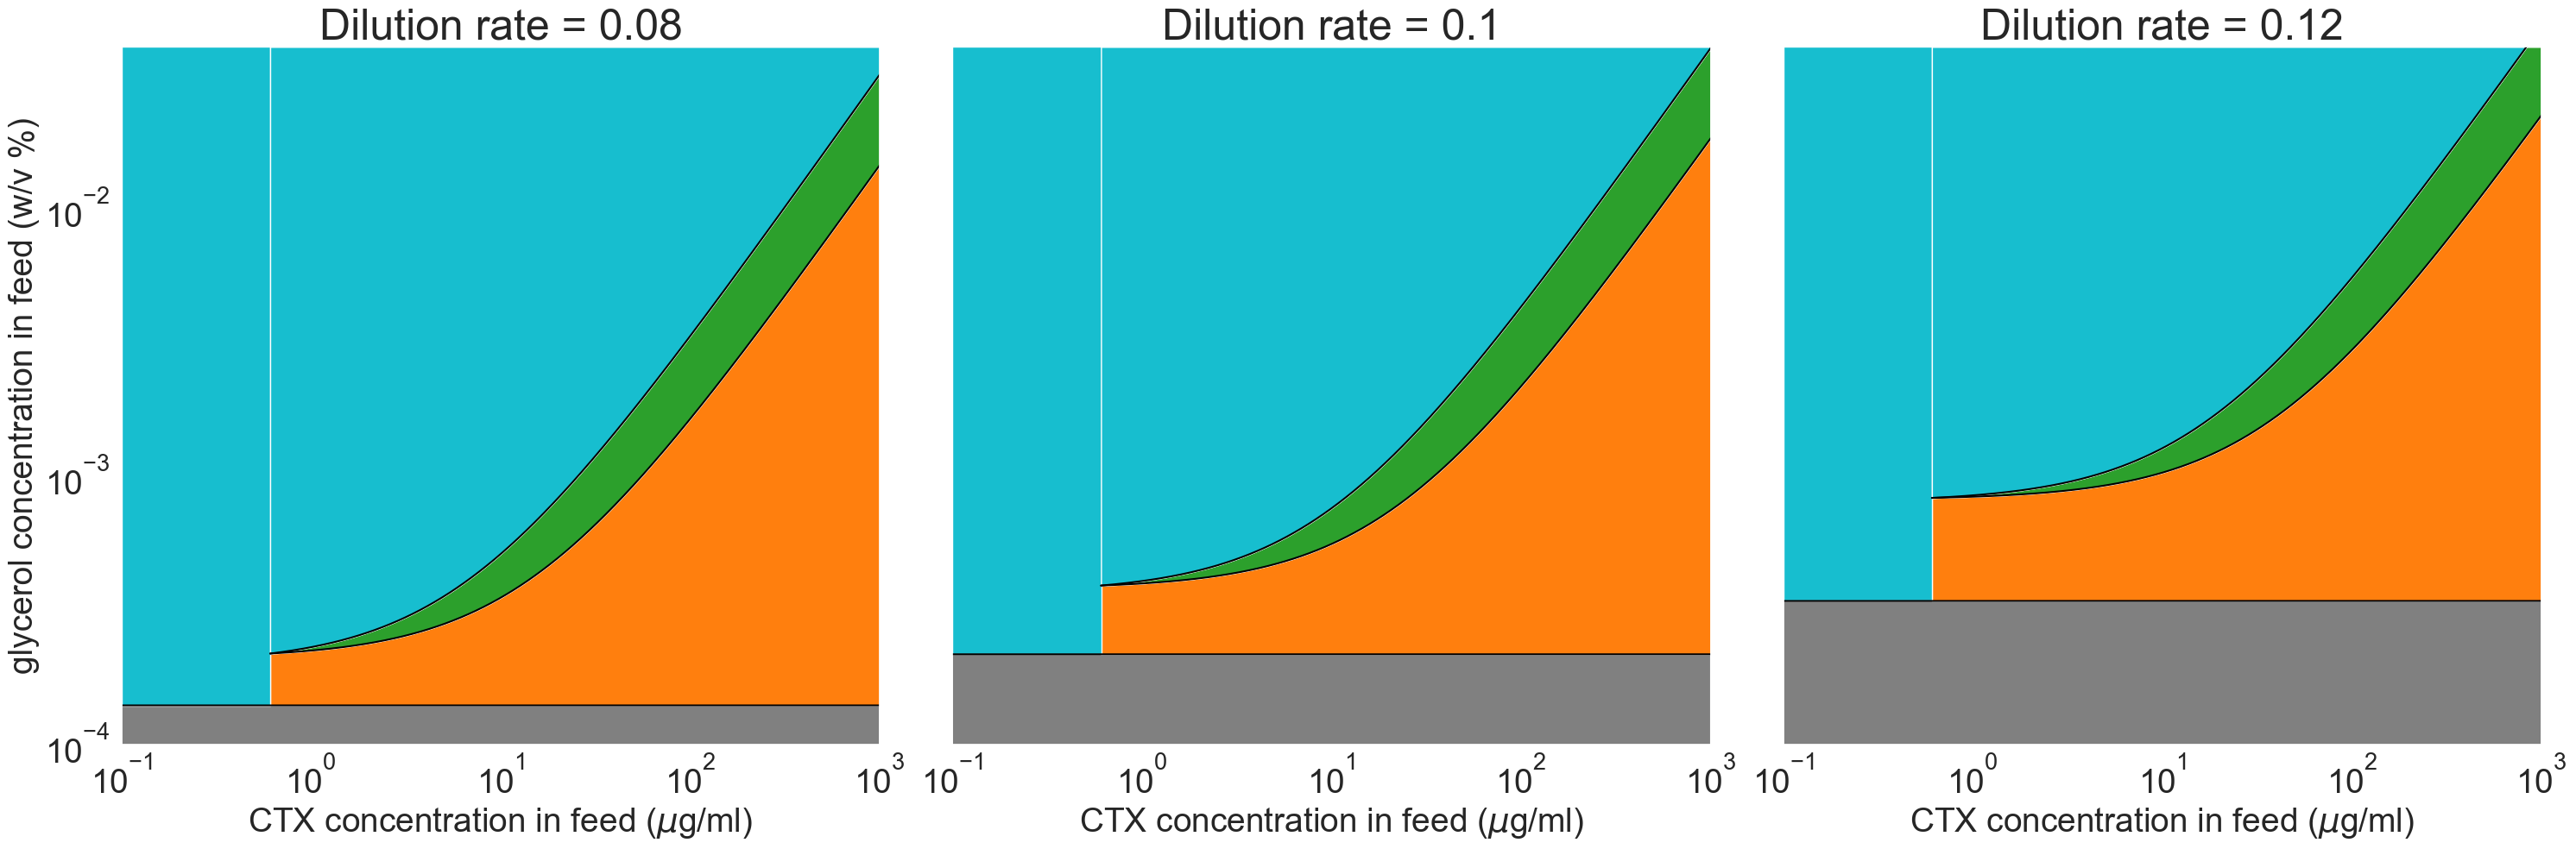

In [52]:
fig, ax = plt.subplots(1,3, figsize=(30,10))

dilution_rates = [0.08, 0.1, 0.12]
feed_a_plot = np.arange(sol_a_eq, 1000, 0.01)
feed_a_plot_long = np.arange(.1, 1000, 0.01)
feed_a_plot_short = np.arange(.1, sol_a_eq+0.01, 0.01)
max_plot_short = np.repeat(0.04, len(feed_a_plot_short))

for i in [0,1,2]:
    d = dilution_rates[i]
    feed_g_R_coex_plot = feed_g_R_coex(feed_a_plot, d, sol_a_eq, muR=growth(sol_a_eq, **p_R), **p_R)
    feed_g_coex_S_plot = feed_g_coex_S(feed_a_plot, d, sol_a_eq, muS=growth(sol_a_eq, **p_S), **p_S)
    min_g_plot = np.repeat(min_g(d), len(feed_a_plot))

    min_g_plot_long = np.repeat(min_g(d), len(feed_a_plot_long))

    min_g_plot_short = np.repeat(min_g(d), len(feed_a_plot_short))
    ax[i].plot(feed_a_plot, feed_g_R_coex_plot, feed_a_plot, feed_g_coex_S_plot, color='black')
    
    ax[i].plot(feed_a_plot_long, min_g_plot_long, color='black')

    ax[i].fill_between(feed_a_plot_long, 0, min_g_plot_long, facecolor='gray')
    ax[i].fill_between(feed_a_plot, min_g_plot, feed_g_R_coex_plot, facecolor='tab:orange')
    ax[i].fill_between(feed_a_plot_short, min_g_plot_short, max_plot_short, facecolor='tab:cyan')
    ax[i].fill_between(feed_a_plot, feed_g_R_coex_plot, feed_g_coex_S_plot, facecolor='tab:green')
    ax[i].fill_between(feed_a_plot, feed_g_coex_S_plot, 0.04, facecolor='tab:cyan')

    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].xaxis.set_tick_params(labelsize=28)
    ax[i].yaxis.set_tick_params(labelsize=28)
    if i>0:
        ax[i].tick_params('y', labelleft=False)

    ax[i].set_xlabel(r'CTX concentration in feed ($\mu$g/ml)', size=28)
    if i==0:
        ax[i].set_ylabel('glycerol concentration in feed (w/v %)', size=28)
    ax[i].set_title('Dilution rate = '+str(d), size=36)

    ax[i].set_ylim(0.0001,0.04)
    ax[i].set_xlim(.1,1000)

plt.tight_layout()
#plt.savefig("timesim_conf.jpg")

(0.1, 1000)

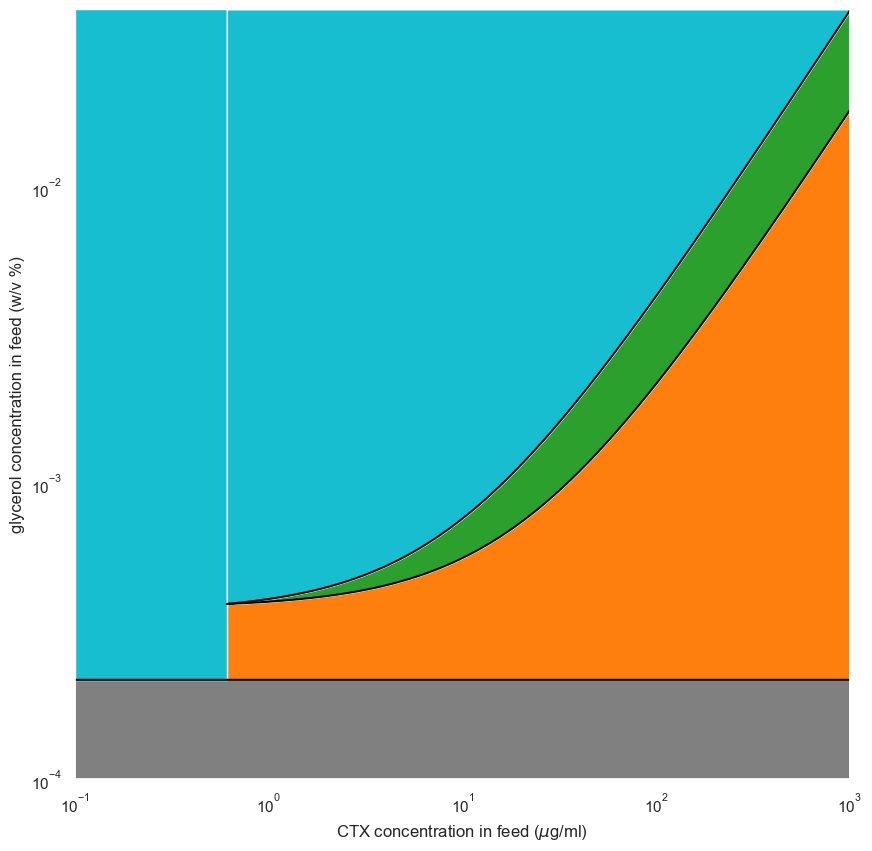

In [53]:
feed_a_plot = np.arange(sol_a_eq, 1000, 0.01)
feed_g_R_coex_plot = feed_g_R_coex(feed_a_plot, 0.1, sol_a_eq, muR=growth(sol_a_eq, **p_R), **p_R)
feed_g_coex_S_plot = feed_g_coex_S(feed_a_plot, 0.1, sol_a_eq, muS=growth(sol_a_eq, **p_S), **p_S)
min_g_plot = np.repeat(min_g(0.1), len(feed_a_plot))

feed_a_plot_long = np.arange(.1, 1000, 0.01)
min_g_plot_long = np.repeat(min_g(0.1), len(feed_a_plot_long))

feed_a_plot_short = np.arange(.1, sol_a_eq+0.01, 0.01)
min_g_plot_short = np.repeat(min_g(0.1), len(feed_a_plot_short))
max_plot_short = np.repeat(0.04, len(feed_a_plot_short))

fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.plot(feed_a_plot, feed_g_R_coex_plot, feed_a_plot, feed_g_coex_S_plot, color='black')

ax.plot(feed_a_plot_long, min_g_plot_long, color='black')

ax.fill_between(feed_a_plot_long, 0, min_g_plot_long, facecolor='gray')
ax.fill_between(feed_a_plot, min_g_plot, feed_g_R_coex_plot, facecolor='tab:orange')
ax.fill_between(feed_a_plot_short, min_g_plot_short, max_plot_short, facecolor='tab:cyan')
ax.fill_between(feed_a_plot, feed_g_R_coex_plot, feed_g_coex_S_plot, facecolor='tab:green')
ax.fill_between(feed_a_plot, feed_g_coex_S_plot, 0.04, facecolor='tab:cyan')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'CTX concentration in feed ($\mu$g/ml)')
ax.set_ylabel('glycerol concentration in feed (w/v %)')

ax.set_ylim(0.0001,0.04)
ax.set_xlim(.1,1000)

(0.1, 1000)

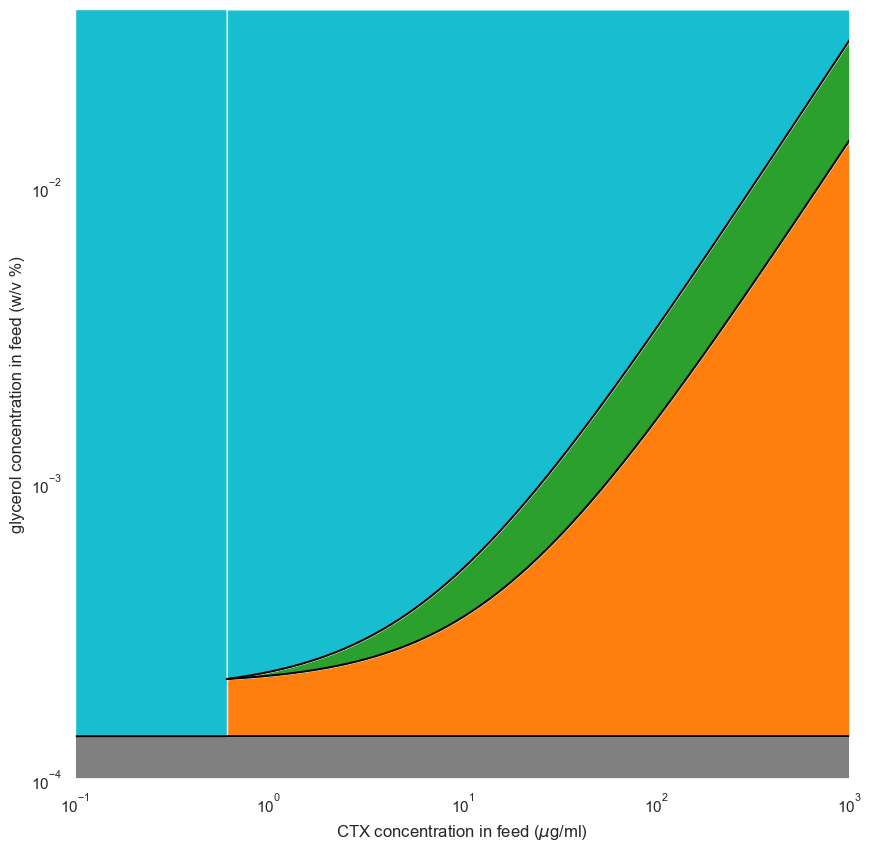

In [54]:
feed_a_plot = np.arange(sol_a_eq, 1000, 0.01)
feed_g_R_coex_plot = feed_g_R_coex(feed_a_plot, 0.08, sol_a_eq, muR=growth(sol_a_eq, **p_R), **p_R)
feed_g_coex_S_plot = feed_g_coex_S(feed_a_plot, 0.08, sol_a_eq, muS=growth(sol_a_eq, **p_S), **p_S)
min_g_plot = np.repeat(min_g(0.08), len(feed_a_plot))

feed_a_plot_long = np.arange(.1, 1000, 0.01)
min_g_plot_long = np.repeat(min_g(0.08), len(feed_a_plot_long))

feed_a_plot_short = np.arange(.1, sol_a_eq+0.01, 0.01)
min_g_plot_short = np.repeat(min_g(0.08), len(feed_a_plot_short))
max_plot_short = np.repeat(0.04, len(feed_a_plot_short))

fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.plot(feed_a_plot, feed_g_R_coex_plot, feed_a_plot, feed_g_coex_S_plot, color='black')

ax.plot(feed_a_plot_long, min_g_plot_long, color='black')

ax.fill_between(feed_a_plot_long, 0, min_g_plot_long, facecolor='gray')
ax.fill_between(feed_a_plot, min_g_plot, feed_g_R_coex_plot, facecolor='tab:orange')
ax.fill_between(feed_a_plot_short, min_g_plot_short, max_plot_short, facecolor='tab:cyan')
ax.fill_between(feed_a_plot, feed_g_R_coex_plot, feed_g_coex_S_plot, facecolor='tab:green')
ax.fill_between(feed_a_plot, feed_g_coex_S_plot, 0.04, facecolor='tab:cyan')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'CTX concentration in feed ($\mu$g/ml)')
ax.set_ylabel('glycerol concentration in feed (w/v %)')

ax.set_ylim(0.0001,0.04)
ax.set_xlim(.1,1000)

(0.1, 1000)

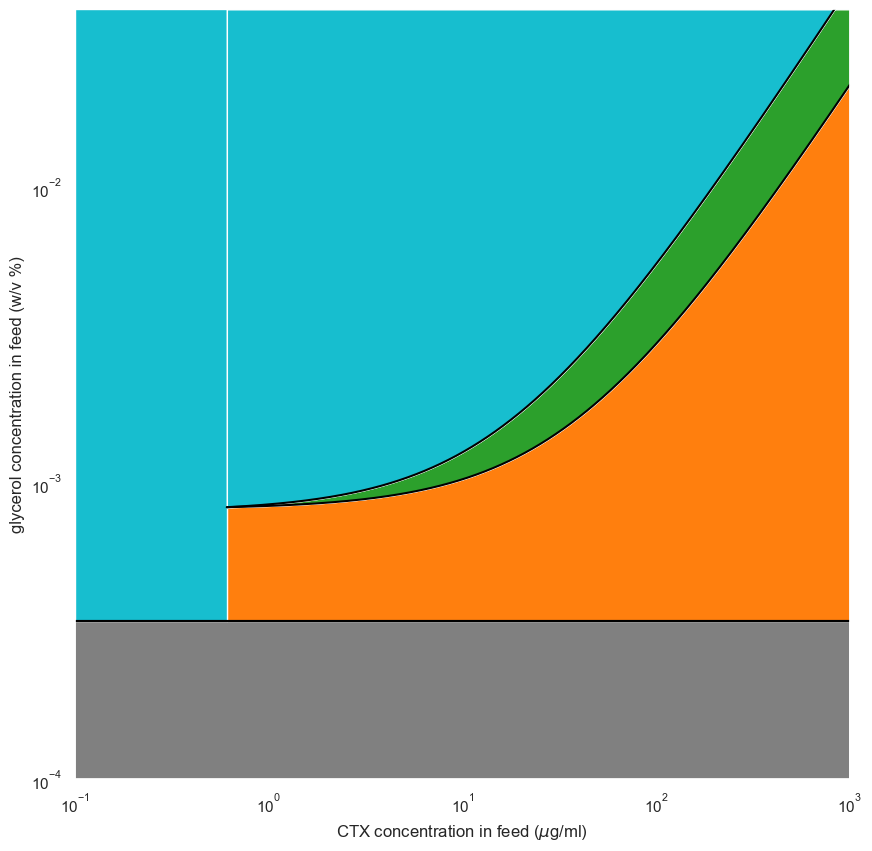

In [55]:
feed_a_plot = np.arange(sol_a_eq, 1000, 0.01)
feed_g_R_coex_plot = feed_g_R_coex(feed_a_plot, 0.12, sol_a_eq, muR=growth(sol_a_eq, **p_R), **p_R)
feed_g_coex_S_plot = feed_g_coex_S(feed_a_plot, 0.12, sol_a_eq, muS=growth(sol_a_eq, **p_S), **p_S)
min_g_plot = np.repeat(min_g(0.12), len(feed_a_plot))

feed_a_plot_long = np.arange(.1, 1000, 0.01)
min_g_plot_long = np.repeat(min_g(0.12), len(feed_a_plot_long))

feed_a_plot_short = np.arange(.1, sol_a_eq+0.01, 0.01)
min_g_plot_short = np.repeat(min_g(0.12), len(feed_a_plot_short))
max_plot_short = np.repeat(0.04, len(feed_a_plot_short))

fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.plot(feed_a_plot, feed_g_R_coex_plot, feed_a_plot, feed_g_coex_S_plot, color='black')

ax.plot(feed_a_plot_long, min_g_plot_long, color='black')

ax.fill_between(feed_a_plot_long, 0, min_g_plot_long, facecolor='gray')
ax.fill_between(feed_a_plot, min_g_plot, feed_g_R_coex_plot, facecolor='tab:orange')
ax.fill_between(feed_a_plot_short, min_g_plot_short, max_plot_short, facecolor='tab:cyan')
ax.fill_between(feed_a_plot, feed_g_R_coex_plot, feed_g_coex_S_plot, facecolor='tab:green')
ax.fill_between(feed_a_plot, feed_g_coex_S_plot, 0.04, facecolor='tab:cyan')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'CTX concentration in feed ($\mu$g/ml)')
ax.set_ylabel('glycerol concentration in feed (w/v %)')

ax.set_ylim(0.0001,0.04)
ax.set_xlim(.1,1000)